Introduction

This document serves as a tutorial for using the TreeTool tool, a software for detecting trees in a point cloud and measuring their diameter at chest height (1.3 m). This document seeks to demonstrate the operation of TreeTool, whether used as a stand-alone application or integrated as a package with other applications.

Usage guide

Below we describe our demo notebook contained in the QuickDemo.ipynb file. This notebook illustrates the operation and use of our software, from loading a point cloud, viewing it, processing it with our algorithm and saving the results.


Load the libraries that we will use and had previously installed

In [4]:
import pclpy
import numpy as np
import Libraries.segTree as segTree
import Libraries.Utils as Utils
import Libraries.Tree_Tool as Tree_Tool
import pandas as pd
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt


Load the point cloud from a .pcd using pclpy, we use our function segTree which contains many helper functions such as voxelize to down sample our point cloud and visualize using our Visualization function built on open3d.

WARNING: Please adjust the path before executing

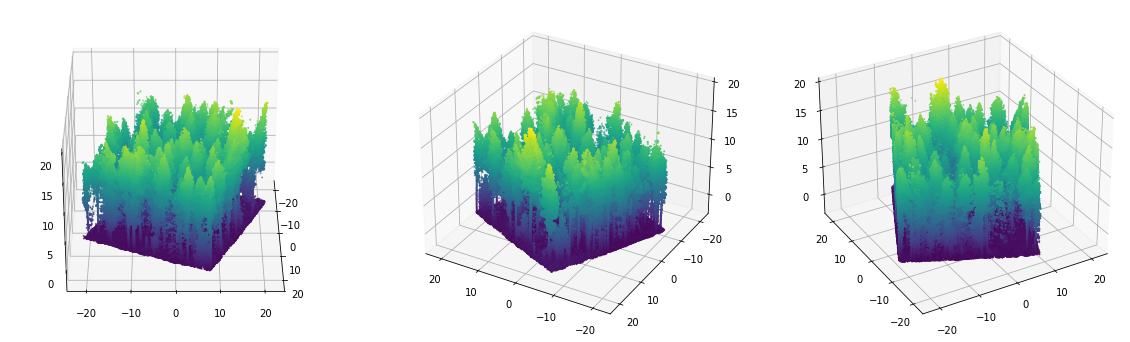

In [5]:
PointCloud = pclpy.pcl.PointCloud.PointXYZ()

filedir = r'../treedata/downsampledlesscloudEURO2.pcd'
pclpy.pcl.io.loadPCDFile(filedir,PointCloud)
PointCloudV = segTree.voxelize(PointCloud.xyz,0.04)
#Utils.open3dpaint(PointCloudV, reduce_for_Vis = True ,voxelsize=0.1)
Utils.open3dpaint(PointCloudV, reduce_for_Vis = True ,voxelsize=0.2)

Tree tool is our main class that containes the routines for tree detection and DBH extraction

In [6]:
Mysegmentor = Tree_Tool.Tree_tool(PointCloudV)

Our tree top object has a series of funtions that are performed to obtain DBH and tree detection.

In [7]:
Mysegmentor.Step_1_Remove_Floor()

#Obtained atributes:
#NongroundCloud: All points in the point cloud that don't belong to the ground
#GroundCloud: All points in the point cloud that belong to the ground
Utils.open3dpaint([Mysegmentor.NongroundCloud,Mysegmentor.GroundCloud],reduce_for_Vis = True ,voxelsize=0.1)

Set Algorithm Parameters

In [6]:
Mysegmentor.set_Ksearch(0.08)

Run main process

In [7]:
#Get point normals for filtering

#Obtained atributes:
#nonFilteredpoints: Same as NongroundCloud
#nonFilterednormals: Normals of points in nonFilteredpoints

#filteredpoints: Points that pass the normal filter
#filterednormals: Normals of points that pass the normal filter
Mysegmentor.Step_2_Normal_Filtering(verticalityThresh=0.06, NonNANcurvatureThresh=0.1)
Utils.open3dpaint([Mysegmentor.NongroundCloud.xyz, Mysegmentor.nonFilteredpoints.xyz + Mysegmentor.nonFilterednormals * 0.1,
                          Mysegmentor.nonFilteredpoints.xyz + Mysegmentor.nonFilterednormals * 0.2],reduce_for_Vis = True ,voxelsize=0.1)

Utils.open3dpaint([Mysegmentor.filteredpoints.xyz , Mysegmentor.filteredpoints.xyz + Mysegmentor.filterednormals * 0.05,
                          Mysegmentor.filteredpoints.xyz + Mysegmentor.filterednormals * 0.1],reduce_for_Vis = True ,voxelsize=0.1)

In [8]:
Mysegmentor.Step_3_Eucladean_Clustering(tol=0.1, minc=40, maxc=6000000)

#Obtained atributes:
#cluster_list: List of all clusteres obtained with Eucladean Clustering

Utils.open3dpaint(Mysegmentor.cluster_list,reduce_for_Vis = True ,voxelsize=0.1)

In [9]:
#Group stem segments
Mysegmentor.Step_4_Group_Stems(max_angle=0.4)

#Obtained atributes:
#cluster_list: List of all complete stems obtained by joining clusters belonging to the same tree
            
Utils.open3dpaint(Mysegmentor.complete_Stems,reduce_for_Vis = True ,voxelsize=0.1)

In [10]:
Mysegmentor.Step_5_Get_Ground_Level_Trees(lowstems_Height=5, cutstems_Height=5)

#Obtained atributes:
#lowstems: List of all stems truncated to the specified height

Utils.open3dpaint(Mysegmentor.lowstems,reduce_for_Vis = True ,voxelsize=0.1)

In [11]:
Mysegmentor.Step_6_Get_Cylinder_Tree_Models(searchRadius=0.1)

#Obtained atributes:
#finalstems: List of Dictionaries with two keys 'tree' which contains the points used to fit the cylinder model and 'model' which contains the cylinder model parameters
#stemcyls: List of the pointclouds that represent the tree modeled with a cylinder

Utils.open3dpaint([i['tree'] for i in Mysegmentor.finalstems] + Mysegmentor.stemcyls,reduce_for_Vis = True ,voxelsize=0.1)
     

In [12]:
Mysegmentor.Step_7_Ellipse_fit()

#Obtained atributes:
#Three new keys in our finalstems dictionaries:
#final_diameter: Final DBH of every tree
#cylinder_diameter: DBH obtained with cylinder fitting
#Ellipse_diameter;DBH obtained with Ellipse fitting

Finally we save the extracted trees and their DBH

In [13]:
Mysegmentor.save_results(savelocation = 'myresults.csv')

Load Cloud and visualize

Use PDAL to apply a Morphological Filter to seperate ground and non ground points. 

WARNIG: Please adjust the path before executing

In [14]:
PointCloud = pclpy.pcl.PointCloud.PointXYZ()
pclpy.pcl.io.loadPCDFile('../treedata/downsampledlesscloudEURO3.pcd',PointCloud)
PointCloudV = segTree.voxelize(PointCloud.xyz,0.05)
Utils.open3dpaint(PointCloudV, reduce_for_Vis = True ,voxelsize=0.1)

In [15]:
Mysegmentor.set_pointcloud(PointCloudV)

In [16]:
Mysegmentor.Full_Process(verticalityThresh=0.06,
    NonNANcurvatureThresh=0.1,
    tol=0.1,
    minc=40,
    maxc=6000000,
    max_angle=0.4,
    lowstems_Height=5,
    cutstems_Height=5,
    searchRadius=0.1)

cloudmatch = [i['tree'] for i in Mysegmentor.finalstems]+[i for i in Mysegmentor.stemcyls]
Utils.open3dpaint(cloudmatch+[PointCloudV], voxelsize=0.2)

Step_1_Remove_Floor
Step_2_Normal_Filtering
Step_3_Eucladean_Clustering
Step_4_Group_Stems
Step_5_Get_Ground_Level_Trees
Step_6_Get_Cylinder_Tree_Models
Step_7_Ellipse_fit
Done


WARNIG: Please adjust the path before executing

In [18]:
#####################################################
#Get ground truth
#treedata = pd.read_csv('E:\Documents\src\TreeTool (2)\TreeData/TLS_Benchmarking_Plot_3_LHD.txt',sep = '\t',names = ['x','y','height','DBH'])
treedata = pd.read_csv('D:/Documentos/ParaAutonomia/Python/Proyecto/Data/EuroSDR_DataRelease/EuroSDR_DataRelease/TLS_Benchmarking_Plot_3_LHD.txt',sep = '\t',names = ['x','y','height','DBH'])
Xcor,Ycor,diam = treedata.iloc[0,[0,1,3]]
surtreesL1 = [Utils.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=20)]
Zcor = 0
TreeDict = [np.array([Xcor,Ycor,diam])]
for i,rows in treedata.iloc[1:].iterrows():
    Xcor,Ycor,diam = rows.iloc[[0,1,3]]
    if not np.any(np.isnan([Xcor,Ycor,diam])):
        surtreesL1.append(Utils.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=10))
        TreeDict.append(np.array([Xcor,Ycor,diam]))
surtrees1 = [p for i in surtreesL1 for p in i]
surtreesCloud1 = pclpy.pcl.PointCloud.PointXYZ(surtrees1)

#DataBase
#Found trees
#Hungarian Algorithm assignment
CostMat = np.ones([len(TreeDict),len(Mysegmentor.stemcyls)])
for X,datatree in enumerate(TreeDict):
    for Y,foundtree in enumerate(Mysegmentor.finalstems):
        CostMat[X,Y] = np.linalg.norm([datatree[0:2]-foundtree['model'][0:2]])

dataindex, foundindex = linear_sum_assignment(CostMat,maximize=False)

#Get metrics
locationerror = []
correctlocationerror = []
diametererror = []
diametererrorElipse = []
diametererrorComb = []
cloudmatch = []
for i,j in zip(dataindex, foundindex):
    locationerror.append(np.linalg.norm((Mysegmentor.finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
    if locationerror[-1]<0.6:
        if Mysegmentor.finalstems[j]['cylinder_diameter'] is not None:
            diametererror.append(abs(Mysegmentor.finalstems[j]['cylinder_diameter']-TreeDict[i][2]))        
            diametererrorElipse.append(abs(Mysegmentor.finalstems[j]['Elipse_diameter']-TreeDict[i][2]))        
            mindi = max(Mysegmentor.finalstems[j]['cylinder_diameter'],Mysegmentor.finalstems[j]['Elipse_diameter'])
            mendi = np.mean([Mysegmentor.finalstems[j]['cylinder_diameter'],Mysegmentor.finalstems[j]['Elipse_diameter']])
            diametererrorComb.append(abs(mindi-TreeDict[i][2]))
            correctlocationerror.append(np.linalg.norm((Mysegmentor.finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
            cloudmatch.append(np.vstack([surtreesL1[i],Mysegmentor.finalstems[j]['tree'],Mysegmentor.stemcyls[j]]))

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Documentos/ParaAutonomia/Python/Proyecto/Data/EuroSDR_DataRelease/EuroSDR_DataRelease/TLS_Benchmarking_Plot_3_LHD.txt'

In [18]:
n_ref = len(TreeDict)
n_match = (len(diametererror))
n_extr = len(locationerror) - n_match

Completeness = n_match/n_ref
Correctness = n_match/(n_extr+n_match)

Total number of trees in Ground Truth:  148
Total number of trees matched with Ground Truth:  79
Total number of trees extra trees found:  0
Percentage of matched trees:  53 %
Percentage of correctly matched trees:  100 %
Cylinder DBH mean Error:  0.01595812077914612
Ellipse DBH mean Error:  0.023044976500011898
Final DBH mean Error:  0.01552007000794052


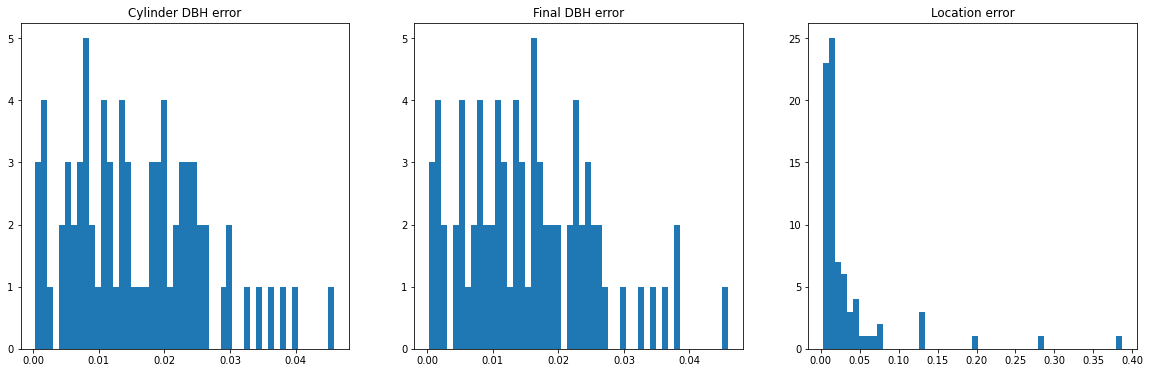

In [25]:
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.hist(diametererror,50)
plt.title('Cylinder DBH error')

plt.subplot(1,3,2)
plt.hist(diametererrorComb,50)
plt.title('Final DBH error')

plt.subplot(1,3,3)
plt.hist(correctlocationerror,50)
plt.title('Location error')

print('Total number of trees in Ground Truth: ', n_ref)
print('Total number of trees matched with Ground Truth: ', n_match)
print('Total number of trees extra trees found: ', n_extr)

print('Percentage of matched trees: ', round(Completeness*100), '%')
print('Percentage of correctly matched trees: ', round(Correctness*100), '%')

print('Cylinder DBH mean Error: ', np.mean(diametererror),)
print('Ellipse DBH mean Error: ', np.mean(diametererrorElipse))
print('Final DBH mean Error: ', np.mean(diametererrorComb))